In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re

In [2]:
def extract_slurm_jobs(start_id, end_id, slurm_df, input_size_dict, output_size_dict):
    
    header=["job_id", 
                "job_name", 
                "total_cpu", 
                "ave_rss_mb", 
                "ave_vmz_mb", 
                "alloc_cpu", 
                "alloc_mem_gb", 
                "ave_read_kb", 
                "ave_write_kb", 
                "elapsed_sec", 
                "cpu_effic",
                "cpu_usage",
                "state", 
                "threads", 
                "srr_id"]
    fields = ['JobID',
              'JobName',
              'TotalCPU',
              'AveRSS',
              'AveVMSize',
              'AllocTRES',
              'AveDiskRead',
              'AveDiskWrite',
              'Elapsed',
              'State',
              'SubmitLine']
    ext_data = []
    
    for job_id in range(start_id, end_id+1):
        job_id_batch = str(job_id) + ".batch"
        
        #print(fields)
        values=df[fields][df["JobID"]==str(job_id)].values[0]
        values_batch=df[fields][df["JobID"]==job_id_batch].values[0]
        
        #print(len(values), values)
        datum = []
        
        job_id = values[0]
        job_name = values[1]
        

     
        if(len(values_batch[2].split(":")) == 2):
            total_cpu = datetime.strptime(values_batch[2],'%M:%S.%f')
            total_cpu = total_cpu.second + total_cpu.minute*60 + (total_cpu.microsecond / 1000000)
        else:
            total_cpu = datetime.strptime(values_batch[2],'%H:%M:%S')
            total_cpu = total_cpu.second + total_cpu.minute*60 + total_cpu.hour*3600
            
        
        
        ave_rss = values_batch[3]
        if ave_rss == "0":
            ave_rss = float(ave_rss)
        else:
            ave_rss = float(ave_rss[:-1])
        
        ave_vmz = values_batch[4]
        if ave_vmz == "0":
            ave_vmz = float(ave_vmz)
        else:
            ave_vmz = float(ave_vmz[:-1])
        
        alloc_tres = values_batch[5].split(",")
        alloc_cpu = int(alloc_tres[0].split("=")[1])
        alloc_mem = int(alloc_tres[1].split("=")[1][0:-1])
        
        ave_read = values_batch[6]
        if ave_read == "0":
            ave_read = float(ave_read)
        else:
            ave_read = float(ave_read[:-1])
            
        ave_write = values_batch[7]
        if ave_write == "0":
            ave_write = float(ave_write)
        else:
            ave_write = float(ave_write[:-1])
            
        
        
        elapsed = datetime.strptime(values_batch[8],'%H:%M:%S')
        elapsed = elapsed.second + elapsed.minute*60 + elapsed.hour*3600
        
        cpu_effic = (total_cpu / (elapsed * alloc_cpu)) * 100
        cpu_usage = alloc_cpu * (cpu_effic/100)
        
        state = values[9]
        submit_line = values[10].split(" ")
        
        #print(submit_line)
        threads = int(submit_line[-2])
        srr_id = submit_line[-1]
        
        input_size = input_size_dict[srr_id]
        output_size = output_size_dict[srr_id]
        
        datum = [job_id,
                   job_name,
                   total_cpu,
                   ave_rss,
                   ave_vmz,
                   alloc_cpu,
                   alloc_mem,
                   ave_read,
                   ave_write,
                   elapsed,
                   cpu_effic,
                   cpu_usage,
                   state,
                   threads,
                   srr_id]
        
        ext_data.append(datum)

    ext_df = pd.DataFrame(ext_data, columns=header)
    return ext_df

def load_sacct_job_dataframe(path):
    fields = "Account|AdminComment|AllocCPUS|AllocNodes|AllocTRES|AssocID|AveCPU|AveCPUFreq|AveDiskRead|AveDiskWrite|AvePages|AveRSS|AveVMSize|BlockID|Cluster|Comment|Constraints|ConsumedEnergy|ConsumedEnergyRaw|Container|CPUTime|CPUTimeRAW|DBIndex|DerivedExitCode|Elapsed|ElapsedRaw|Eligible|End|ExitCode|Flags|GID|Group|JobID|JobIDRaw|JobName|Layout|MaxDiskRead|MaxDiskReadNode|MaxDiskReadTask|MaxDiskWrite|MaxDiskWriteNode|MaxDiskWriteTask|MaxPages|MaxPagesNode|MaxPagesTask|MaxRSS|MaxRSSNode|MaxRSSTask|MaxVMSize|MaxVMSizeNode|MaxVMSizeTask|McsLabel|MinCPU|MinCPUNode|MinCPUTask|NCPUS|NNodes|NodeList|NTasks|Partition|Priority|QOS|QOSRAW|Reason|ReqCPUFreq|ReqCPUFreqGov|ReqCPUFreqMax|ReqCPUFreqMin|ReqCPUS|ReqMem|ReqNodes|ReqTRES|Reservation|ReservationId|Reserved|ResvCPU|ResvCPURAW|Start|State|Submit|SubmitLine|Suspended|SystemComment|SystemCPU|Timelimit|TimelimitRaw|TotalCPU|TRESUsageInAve|TRESUsageInMax|TRESUsageInMaxNode|TRESUsageInMaxTask|TRESUsageInMin|TRESUsageInMinNode|TRESUsageInMinTask|TRESUsageInTot|TRESUsageOutAve|TRESUsageOutMax|TRESUsageOutMaxNode|TRESUsageOutMaxTask|TRESUsageOutMin|TRESUsageOutMinNode|TRESUsageOutMinTask|TRESUsageOutTot|UID|User|UserCPU|WCKey|WCKeyID|WorkDir"
    fields = fields.split("|")
    df = pd.read_csv(path, sep="|", names=fields)
    return df

def get_file_size_dict(file_path):

    # SIZE IN BYTES
    
    files = open(file_path, "r")

    # reading the file
    data = files.read()

    data_into_list = [i for i in data.split("\n")[1:] if i != '']
    size_dict = dict()
    for data in data_into_list:
        splitted_data = re.split('\s+', data)
        print(splitted_data)
        size = splitted_data[4]
        srr_id = splitted_data[-1].split(".")[0]
        size_dict[srr_id] = int(size)
    
    files.close()
    return size_dict

def generate_comprehensive_dataframe(path):
    comp_data = []
    stats_df_list = []
    header = ["job_id", "job_name", "alloc_cpu", "alloc_mem_gb", "elapsed_sec", "state", "threads", "sra_id", "input_size", "output_size"]
    
    input_size_dict = get_file_size_dict(f"{path}/file_size/input_files.txt")
    output_size_dict = get_file_size_dict(f"{path}/file_size/output_files.txt")
    
    sacct_df = load_sacct_job_dataframe(f"{path}/stats/sacct.txt")
    fields = ["JobID", "JobName", "AllocTRES", "Elapsed", "State", "SubmitLine"]
    job_ids = [int(i) for i in sacct_df["JobID"].values if "batch" not in i]
    for job_id in job_ids:
        job_id_batch = str(job_id) + ".batch"
        values=sacct_df[fields][sacct_df["JobID"]==str(job_id)].values[0]
        values_batch=sacct_df[fields][sacct_df["JobID"]==job_id_batch].values[0]

        job_id = int(values[0])
        job_name = values[1]
        
        alloc_tres = values_batch[2].split(",")
        alloc_cpu = int(alloc_tres[0].split("=")[1])
        alloc_mem = int(alloc_tres[1].split("=")[1][0:-1])

        elapsed = datetime.strptime(values_batch[3],'%H:%M:%S')
        elapsed = elapsed.second + elapsed.minute*60 + elapsed.hour*3600

        state = values[4]
        submit_line = values[5].split(" ")
        
        threads = int(submit_line[-2])
        srr_id = submit_line[-1]

        input_size = input_size_dict[srr_id]
        output_size = output_size_dict[srr_id]
        
        datum = [job_id,
           job_name,
           alloc_cpu,
           alloc_mem,
           elapsed,
           state,
           threads,
           srr_id,
           input_size,
           output_size]
        comp_data.append(datum)
        
        stats_df = load_stat_dataframe_of_job(path, job_id)
        if stats_df is not None:
            stats_df_list.append(stats_df)
        
    stats_df = pd.concat(stats_df_list, ignore_index=True, axis=0)
    comp_df = pd.DataFrame(comp_data, columns=header)
    comp_df = pd.merge(comp_df, stats_df, on='job_id', how='outer')
    
    return comp_df

def load_stat_dataframe_of_job(dir, job_id):
    from pandas.errors import EmptyDataError 
    
    stats_df = None
    
    try:
        stats_df = pd.read_csv(f"{dir}/stats/{job_id}_stat.csv")
        stats_df = stats_df.astype({"job_id": int, "pid": int, "cpu": float, "vsz_bytes": int, "rss_bytes": int, "read_bytes": int, "write_bytes": int})
    except (FileNotFoundError, EmptyDataError):
        pass
        
        
    return stats_df    

def drop_null_data(df):
    print("SIZE BEFORE DROPPING:", df.shape)
    dfresult = df.dropna()
    print("SIZE BEFORE DROPPING:", dfresult.shape)
    print(f"DROP {df.shape[0] - dfresult.shape[0]} rows") 
    return dfresult
    
def summarize_dataframe(df):
    df = df.drop(['timestamp'], axis=1)
    header = ["job_id", "job_name", 'alloc_cpu', 'alloc_mem_gb', 'elapsed_sec', 'state', 'threads', 'sra_id', 'input_size', 'output_size', 'pid', "n_pack", "pack_id", "ave_cpu", "peak_cpu", "ave_vsz", "peak_vsz", "ave_rss", "peak_rss","read_bytes","write_bytes"]
    sum_data = []
    
    job_ids = df["job_id"].unique()

    for j_id in job_ids:
        stats = df[df["job_id"] == j_id]

        job_id = stats["job_id"].iloc[0]
        job_name = stats["job_name"].iloc[0]
        alloc_cpu = stats["alloc_cpu"].iloc[0]
        alloc_mem = stats["alloc_mem_gb"].iloc[0]
        elapsed_sec = stats["elapsed_sec"].iloc[0]
        state = stats["state"].iloc[0]
        threads = stats["threads"].iloc[0]
        sra_id = stats["sra_id"].iloc[0]
        input_size = stats["input_size"].iloc[0]
        output_size = stats["output_size"].iloc[0]
        pid = stats["pid"].iloc[0]
        n_pack = stats["n_pack"].iloc[0]
        pack_id = stats["pack_id"].iloc[0]
        
        ave_cpu = stats["cpu"].mean()
        peak_cpu = stats["cpu"].max()
        
        ave_vsz = stats["vsz_bytes"].mean()
        peak_vsz = stats["vsz_bytes"].max()

        ave_rss = stats["rss_bytes"].mean()
        peak_rss = stats["rss_bytes"].max()
        
        read = stats["read_bytes"].max()
        write = stats["write_bytes"].max()

        datum = [
            job_id,
            job_name,
            alloc_cpu,
            alloc_mem,
            elapsed_sec,
            state,
            threads,
            sra_id,
            input_size,
            output_size,
            pid,
            n_pack,
            pack_id,
            ave_cpu,
            peak_cpu,
            ave_vsz,
            peak_vsz,
            ave_rss,
            peak_rss,
            read,
            write
        ]
        sum_data.append(datum)

    sum_df = pd.DataFrame(sum_data, columns=header)
    
    # df = df.groupby(['job_id', 'job_name', 'alloc_cpu', 'alloc_mem_gb', 'elapsed_sec', 'state', 'threads', 'sra_id', 'input_size', 'output_size', 'pid', "n_pack", "pack_id"]).mean()
    return sum_df

In [3]:
DIR = "/home/cc/research/bwa_mem"
DIR = "./"

In [4]:
comp_df = generate_comprehensive_dataframe(DIR)

['-rw-rw-r--', '1', 'cc', 'cc', '652502436', 'Jul', '13', '03:42', 'SRR1658393.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '844756816', 'Jul', '13', '03:42', 'SRR2059426.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '1006917152', 'Jul', '13', '03:42', 'SRR2059427.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '1311319762', 'Jul', '13', '03:42', 'SRR2059428.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '604731342', 'Jul', '13', '03:42', 'SRR2059429.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '1155384344', 'Jul', '13', '03:42', 'SRR2059430.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '687297970', 'Jul', '13', '03:42', 'SRR2059431.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '1082634986', 'Jul', '13', '03:42', 'SRR2059432.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '1434756540', 'Jul', '13', '03:42', 'SRR2059433.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '1350726332', 'Jul', '13', '03:42', 'SRR2059434.fastq']
['-rw-rw-r--', '1', 'cc', 'cc', '430124654', 'Jul', '13', '10:41', 'SRR1658393.sam']
['-rw-rw-r--', '1', 'cc', 'cc', '515558

In [5]:
# CHECK NULL DATA
comp_df[comp_df.isna().any(axis=1)]

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,threads,sra_id,input_size,output_size,timestamp,pid,n_pack,pack_id,cpu,vsz_bytes,rss_bytes,read_bytes,write_bytes
980758,14950,single_bwa.sh,4,16,822,COMPLETED,16,SRR2059428,1311319762,816740889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1263431,21650,single_bwa.sh,8,16,374,COMPLETED,4,SRR1658393,652502436,430124654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1388036,21651,single_bwa.sh,32,16,38,COMPLETED,16,SRR1658393,652502436,430124654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2146923,21652,single_bwa.sh,8,16,364,COMPLETED,8,SRR1658393,652502436,430124654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2692540,21649,single_bwa.sh,16,64,374,COMPLETED,32,SRR1658393,652502436,430124654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# DROP NULL DATA 
comp_df = drop_null_data(comp_df)

SIZE BEFORE DROPPING: (3488833, 19)
SIZE BEFORE DROPPING: (3488828, 19)
DROP 5 rows


In [7]:
sum_df = summarize_dataframe(comp_df)

In [8]:
sum_df

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,threads,sra_id,input_size,output_size,...,n_pack,pack_id,ave_cpu,peak_cpu,ave_vsz,peak_vsz,ave_rss,peak_rss,read_bytes,write_bytes
0,12833,single_bwa.sh,8,8,440,COMPLETED,8,SRR2059427,1006917152,625008229,...,4.0,472.0,100.379081,803.0,5.630365e+09,8.277459e+09,4.792467e+09,7.909827e+09,1.314005e+09,625008640.0
1,14184,single_bwa.sh,8,16,695,COMPLETED,2,SRR2059430,1155384344,694113997,...,3.0,1030.0,29.966989,252.0,5.060029e+09,6.199386e+09,4.391293e+09,5.990662e+09,4.375663e+09,544935936.0
2,19657,single_bwa.sh,8,32,277,COMPLETED,16,SRR1658393,652502436,430124654,...,4.0,403.0,130.805874,803.0,4.811460e+09,9.808855e+09,3.916531e+09,9.419117e+09,1.212543e+09,430137344.0
3,20364,single_bwa.sh,32,8,371,OUT_OF_MEMORY,16,SRR2059432,1082634986,684927419,...,2.0,699.0,56.654403,1645.0,4.216377e+09,9.281688e+09,3.289762e+09,8.544256e+09,2.139333e+09,4096.0
4,16251,single_bwa.sh,4,8,417,COMPLETED,8,SRR2059431,687297970,423971216,...,4.0,1888.0,64.410060,402.0,5.071821e+09,8.126468e+09,4.373864e+09,7.494259e+09,2.125324e+09,381620224.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,12270,single_bwa.sh,32,64,281,COMPLETED,2,SRR2059431,687297970,423971216,...,2.0,245.0,62.600303,242.0,5.444829e+09,6.333604e+09,4.980751e+09,6.114710e+09,2.292916e+09,353857536.0
7991,12079,single_bwa.sh,2,16,262,COMPLETED,32,SRR2059429,604731342,377159582,...,2.0,163.0,92.648478,201.0,5.752623e+09,8.797225e+09,4.082573e+09,8.410898e+09,2.662113e+09,377167872.0
7992,19399,single_bwa.sh,4,64,855,COMPLETED,2,SRR2059433,1434756540,874254433,...,3.0,296.0,38.758004,276.0,4.716506e+09,6.467822e+09,3.826116e+09,6.203412e+09,2.293314e+09,116674560.0
7993,19981,single_bwa.sh,32,16,780,COMPLETED,32,SRR2059428,1311319762,816740889,...,2.0,537.0,79.797925,3118.0,6.429074e+09,1.195914e+10,5.833991e+09,1.126584e+10,5.125652e+08,816754688.0


In [9]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7995 entries, 0 to 7994
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job_id        7995 non-null   int64  
 1   job_name      7995 non-null   object 
 2   alloc_cpu     7995 non-null   int64  
 3   alloc_mem_gb  7995 non-null   int64  
 4   elapsed_sec   7995 non-null   int64  
 5   state         7995 non-null   object 
 6   threads       7995 non-null   int64  
 7   sra_id        7995 non-null   object 
 8   input_size    7995 non-null   int64  
 9   output_size   7995 non-null   int64  
 10  pid           7995 non-null   float64
 11  n_pack        7995 non-null   float64
 12  pack_id       7995 non-null   float64
 13  ave_cpu       7995 non-null   float64
 14  peak_cpu      7995 non-null   float64
 15  ave_vsz       7995 non-null   float64
 16  peak_vsz      7995 non-null   float64
 17  ave_rss       7995 non-null   float64
 18  peak_rss      7995 non-null 

# Analysis

In [10]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

In [11]:
completed_df

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,threads,sra_id,input_size,output_size,...,n_pack,pack_id,ave_cpu,peak_cpu,ave_vsz,peak_vsz,ave_rss,peak_rss,read_bytes,write_bytes
0,12833,single_bwa.sh,8,8,440,COMPLETED,8,SRR2059427,1006917152,625008229,...,4.0,472.0,100.379081,803.0,5.630365e+09,8.277459e+09,4.792467e+09,7.909827e+09,1.314005e+09,625008640.0
1,14184,single_bwa.sh,8,16,695,COMPLETED,2,SRR2059430,1155384344,694113997,...,3.0,1030.0,29.966989,252.0,5.060029e+09,6.199386e+09,4.391293e+09,5.990662e+09,4.375663e+09,544935936.0
2,19657,single_bwa.sh,8,32,277,COMPLETED,16,SRR1658393,652502436,430124654,...,4.0,403.0,130.805874,803.0,4.811460e+09,9.808855e+09,3.916531e+09,9.419117e+09,1.212543e+09,430137344.0
4,16251,single_bwa.sh,4,8,417,COMPLETED,8,SRR2059431,687297970,423971216,...,4.0,1888.0,64.410060,402.0,5.071821e+09,8.126468e+09,4.373864e+09,7.494259e+09,2.125324e+09,381620224.0
5,12580,single_bwa.sh,32,32,575,COMPLETED,2,SRR2059434,1350726332,842951903,...,2.0,364.0,70.036475,282.0,3.902759e+09,6.467822e+09,3.493602e+09,6.230659e+09,2.454147e+09,842985472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,12270,single_bwa.sh,32,64,281,COMPLETED,2,SRR2059431,687297970,423971216,...,2.0,245.0,62.600303,242.0,5.444829e+09,6.333604e+09,4.980751e+09,6.114710e+09,2.292916e+09,353857536.0
7991,12079,single_bwa.sh,2,16,262,COMPLETED,32,SRR2059429,604731342,377159582,...,2.0,163.0,92.648478,201.0,5.752623e+09,8.797225e+09,4.082573e+09,8.410898e+09,2.662113e+09,377167872.0
7992,19399,single_bwa.sh,4,64,855,COMPLETED,2,SRR2059433,1434756540,874254433,...,3.0,296.0,38.758004,276.0,4.716506e+09,6.467822e+09,3.826116e+09,6.203412e+09,2.293314e+09,116674560.0
7993,19981,single_bwa.sh,32,16,780,COMPLETED,32,SRR2059428,1311319762,816740889,...,2.0,537.0,79.797925,3118.0,6.429074e+09,1.195914e+10,5.833991e+09,1.126584e+10,5.125652e+08,816754688.0


In [16]:
from scipy.stats.stats import pearsonr

def calculate_correlation(df, features, target):
    
    corr_dict = dict()
    y = df[target]
    for col in features:
        
        x = df[col]
        corr, _ =  pearsonr(x, y)
        corr_dict[col] = corr
    
  
    corr_df = pd.Series(corr_dict)
    corr_df.index = features
    corr_df.sort_values(ascending=False).plot.bar(figsize=(20, 8))
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda x:np.abs(x[1]), reverse=True))
    
    return sorted_corr_dict


/tmp/ipykernel_1126775/616510216.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


{'output_size': 0.6084173488121344,
 'ave_cpu': -0.6051268707932249,
 'input_size': 0.6006723375159068,
 'write_bytes': 0.4306584954736332,
 'peak_cpu': -0.1668116856199842,
 'alloc_cpu': -0.14082594776334093,
 'n_pack': 0.11894321100031383,
 'thread_ratio': 0.08029215474547238,
 'peak_rss': 0.07765234243563932,
 'threads': -0.06872699179628895,
 'peak_vsz': 0.057313788507592785,
 'ave_rss': 0.04800502267129024,
 'ave_vsz': 0.04244017747885064,
 'read_bytes': -0.03257884638239584,
 'alloc_mem_gb': -0.0048477786823098645}

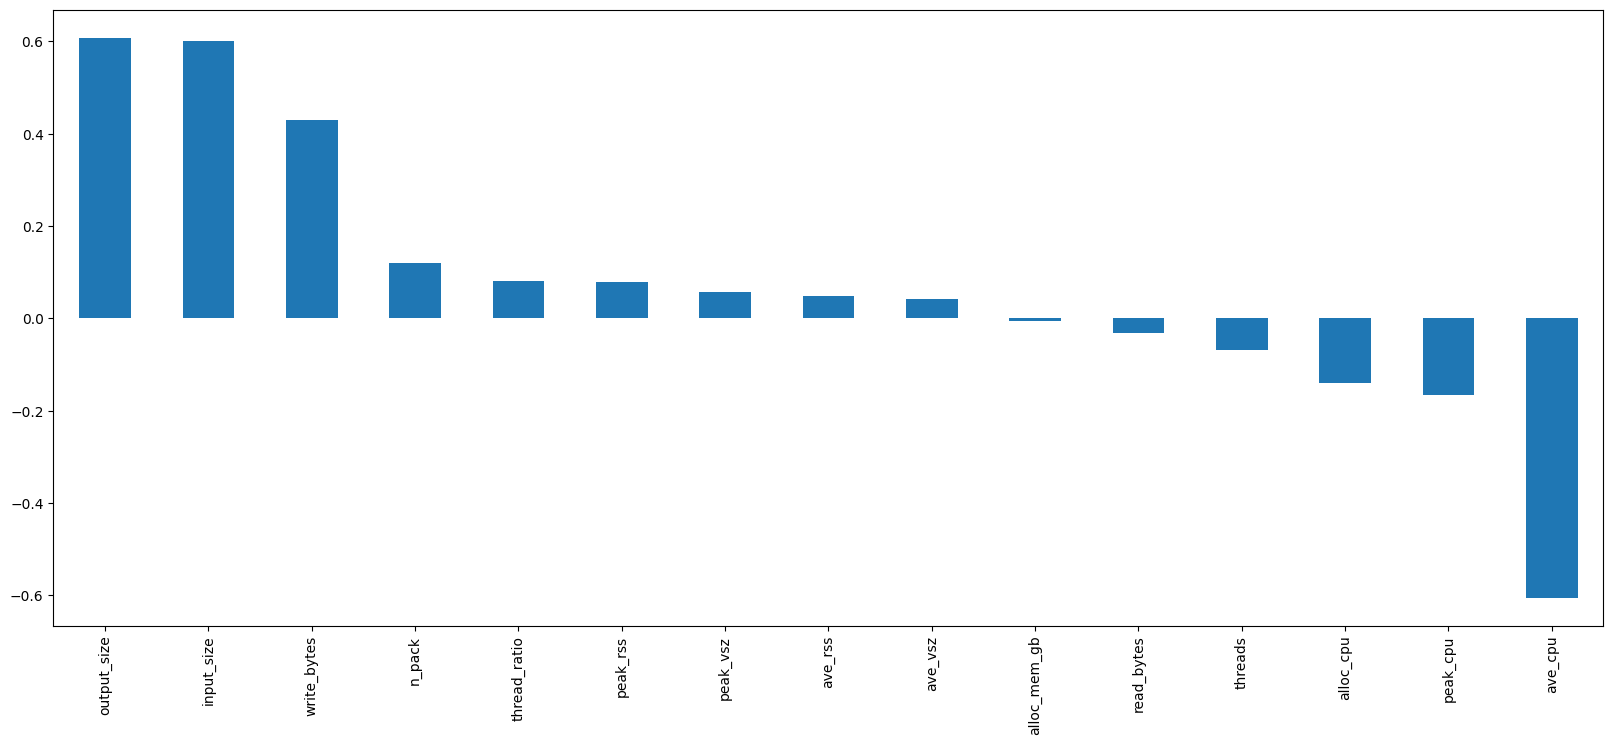

In [17]:
features =  ["alloc_cpu", "alloc_mem_gb", "input_size", "output_size", "threads", "thread_ratio", "n_pack", "ave_cpu", "peak_cpu", "ave_vsz", "peak_vsz", "ave_rss", "peak_rss", "read_bytes", "write_bytes"]
target = "elapsed_sec"
calculate_correlation(completed_df, features, target)

## Pre-execution Features

Text(0.5, 0.0, 'Number of Allocated CPU')

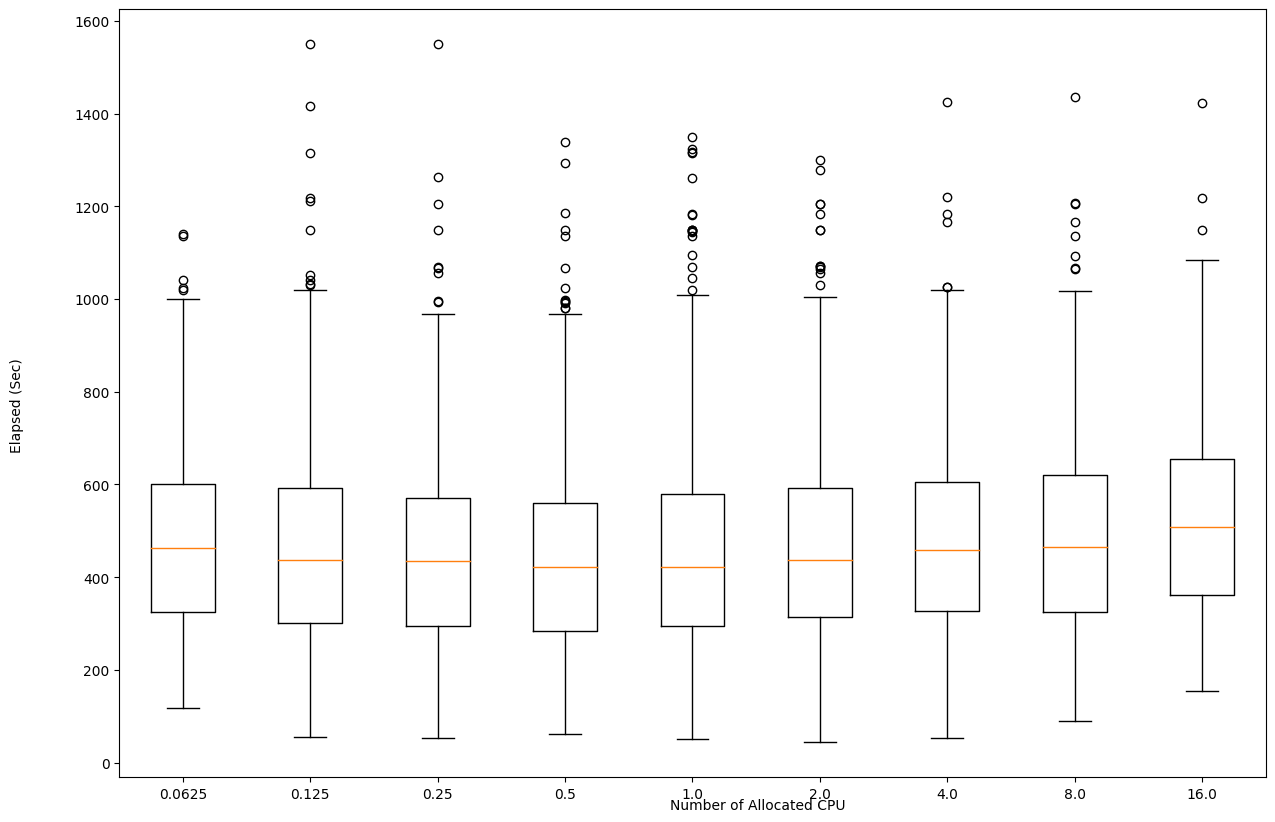

In [22]:
target = "thread_ratio"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())

fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)


#filtered_df = completed_df[completed_df["sra_id"] == s_id]
data = dict()

for n_target in target_unique:
    data[str(n_target)] = completed_df[completed_df[target] == n_target]["elapsed_sec"]

x = completed_df[target]
y = completed_df["elapsed_sec"]
corr, _ =  pearsonr(x, y)
ax.boxplot(data.values())
ax.set_xticks(np.arange(1, len(target_unique)+1), target_unique)
#ax.set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Number of Allocated CPU', va='center', rotation='horizontal')

Text(0.5, 0.0, 'Number of Allocated CPU')

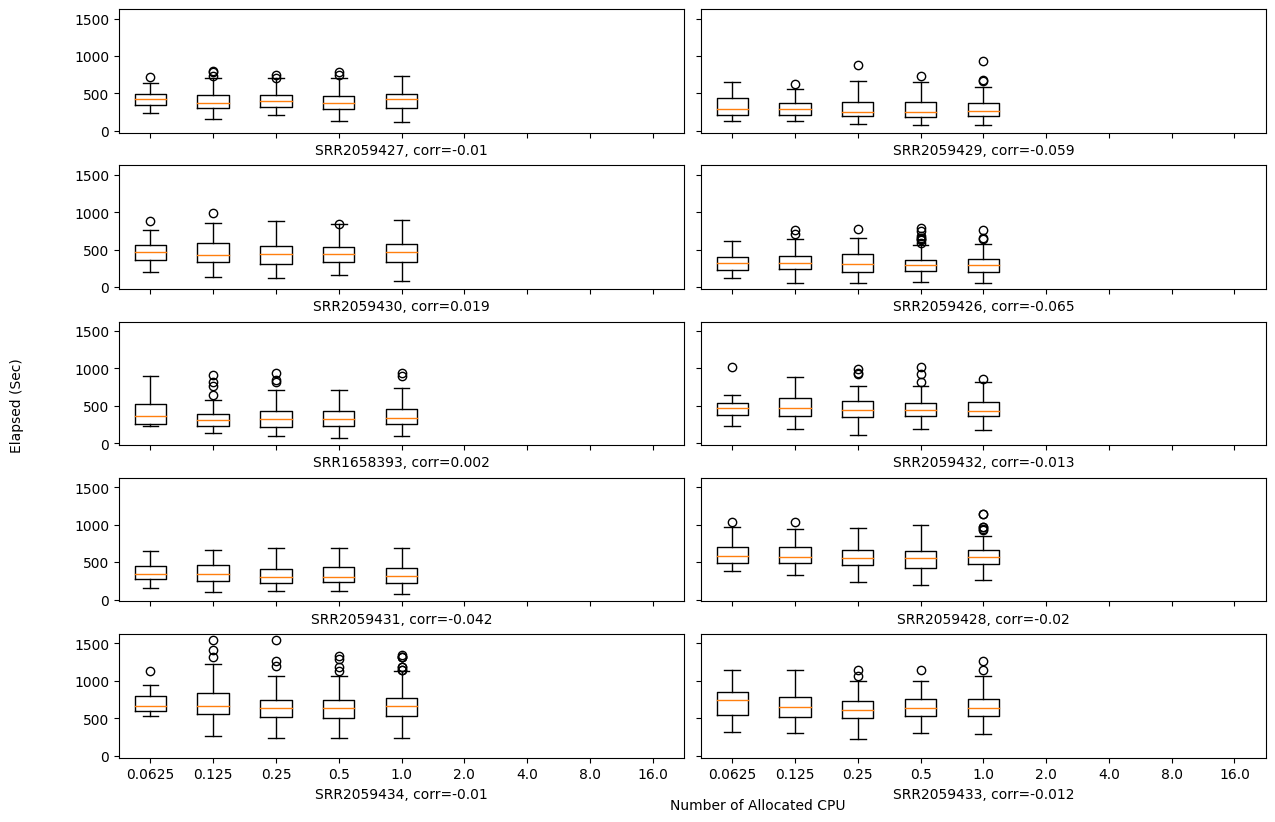

In [25]:
target = "thread_ratio"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[(completed_df["sra_id"] == s_id) & (completed_df[target] <= 1)]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Number of Allocated CPU', va='center', rotation='horizontal')

Text(0.5, 0.0, 'Number of Allocated CPU')

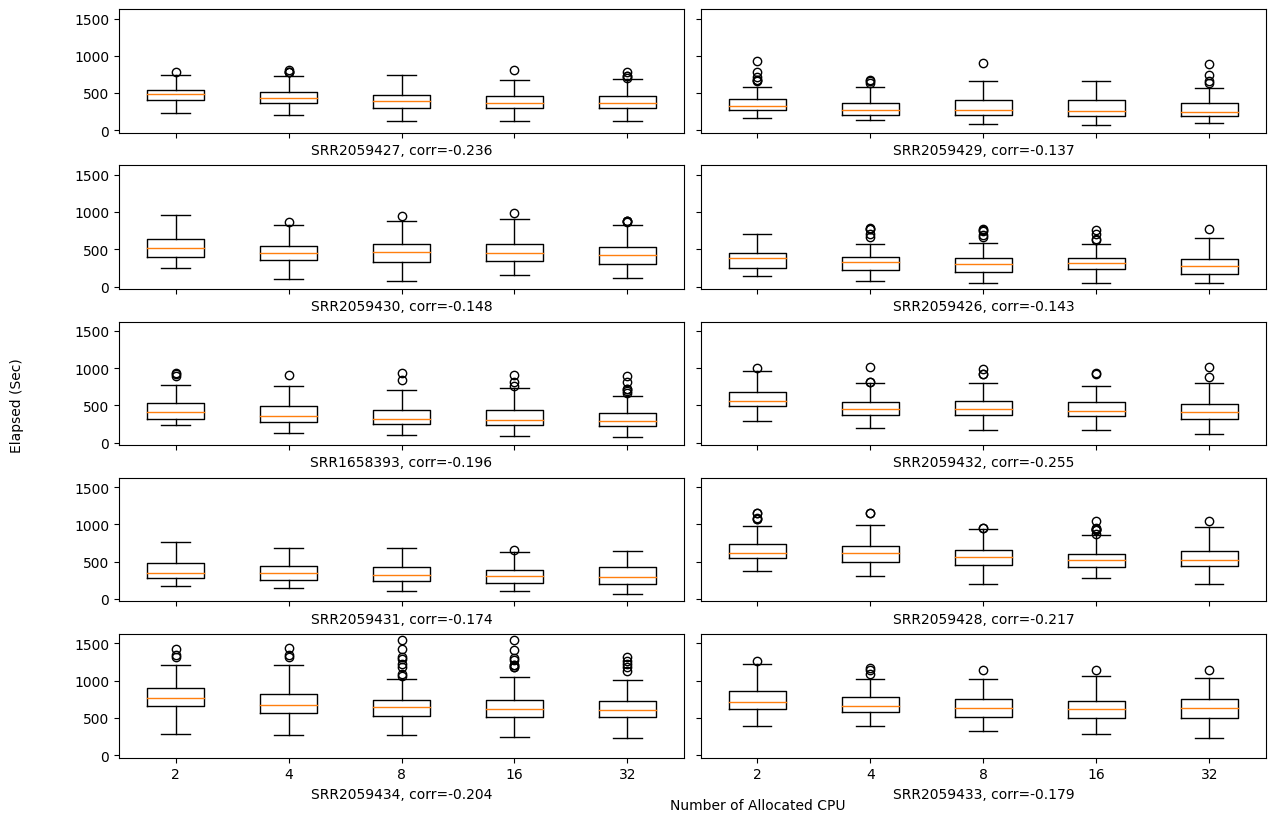

In [22]:
target = "alloc_cpu"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Number of Allocated CPU', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Number of Allocated Memory (GB)')

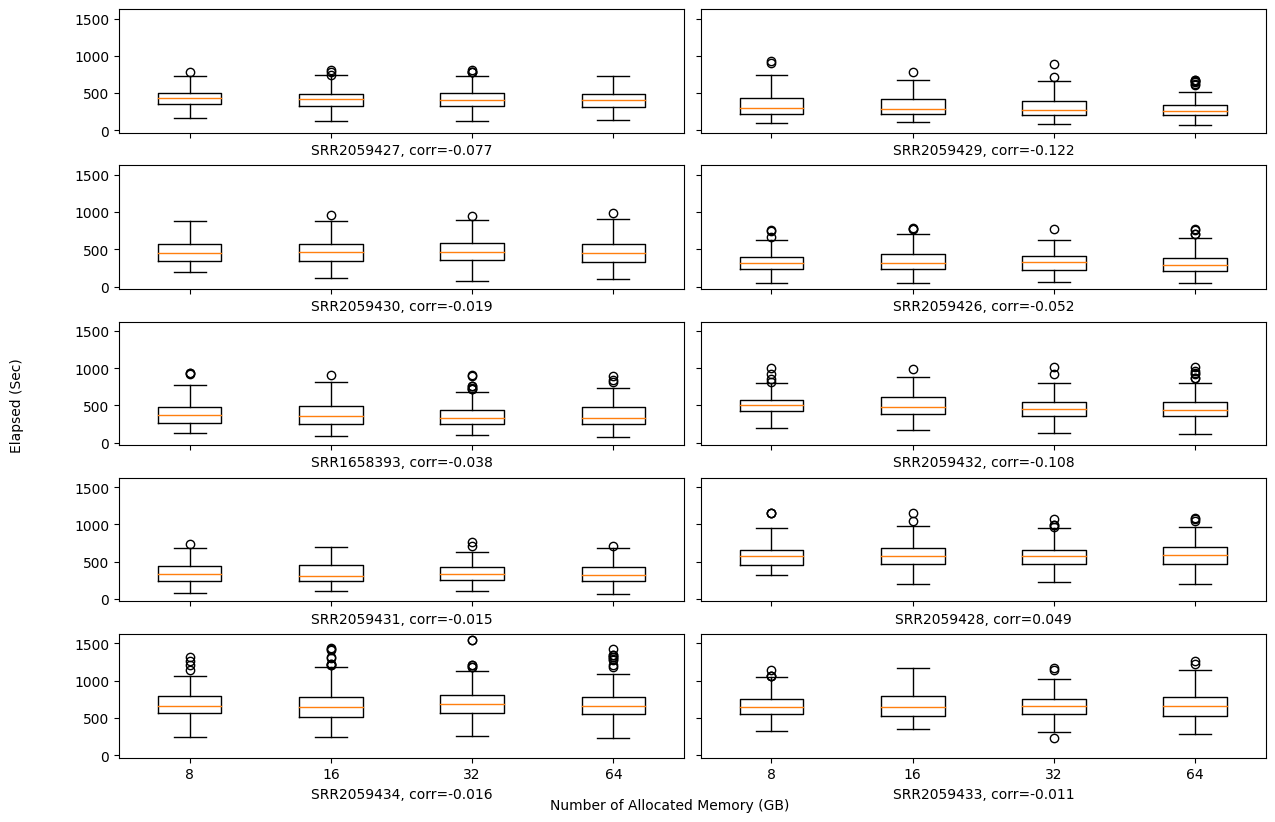

In [23]:
target = "alloc_mem_gb"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Number of Allocated Memory (GB)', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

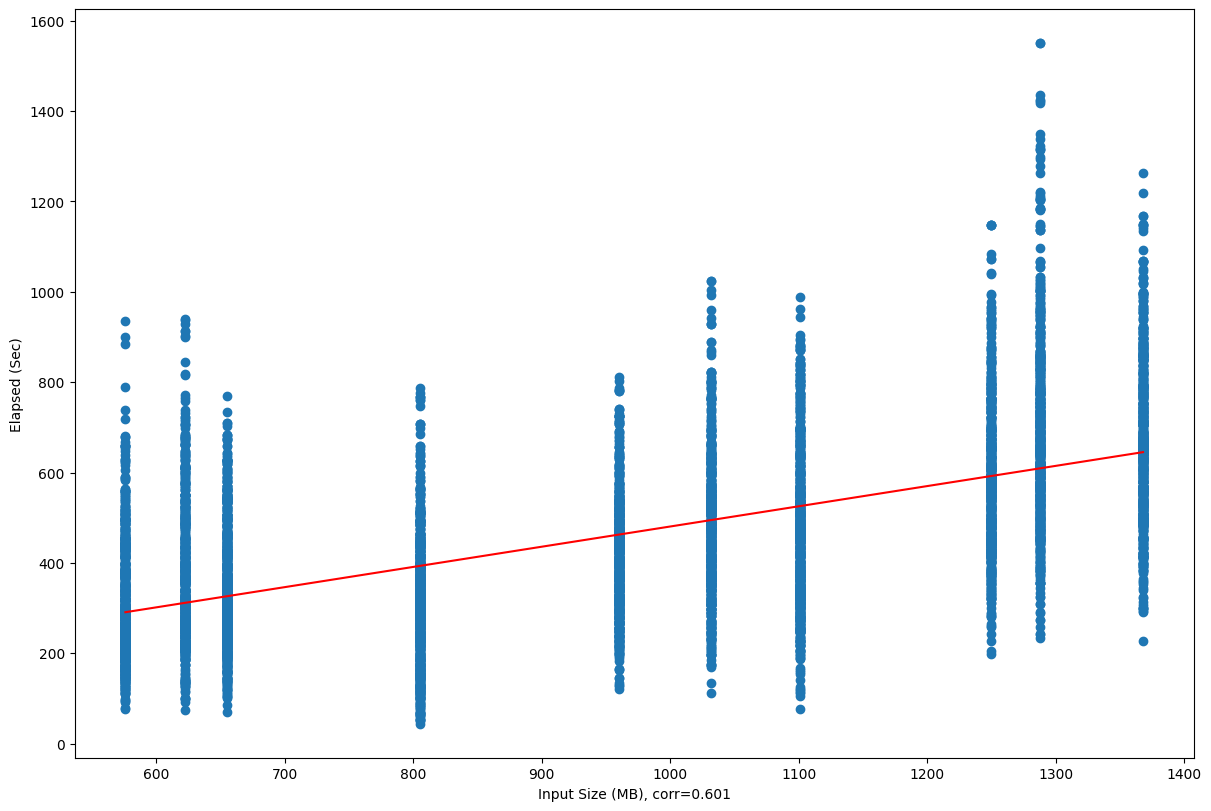

In [24]:
target = "input_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Input Size (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

Text(0.45, 0.0, 'Thread')

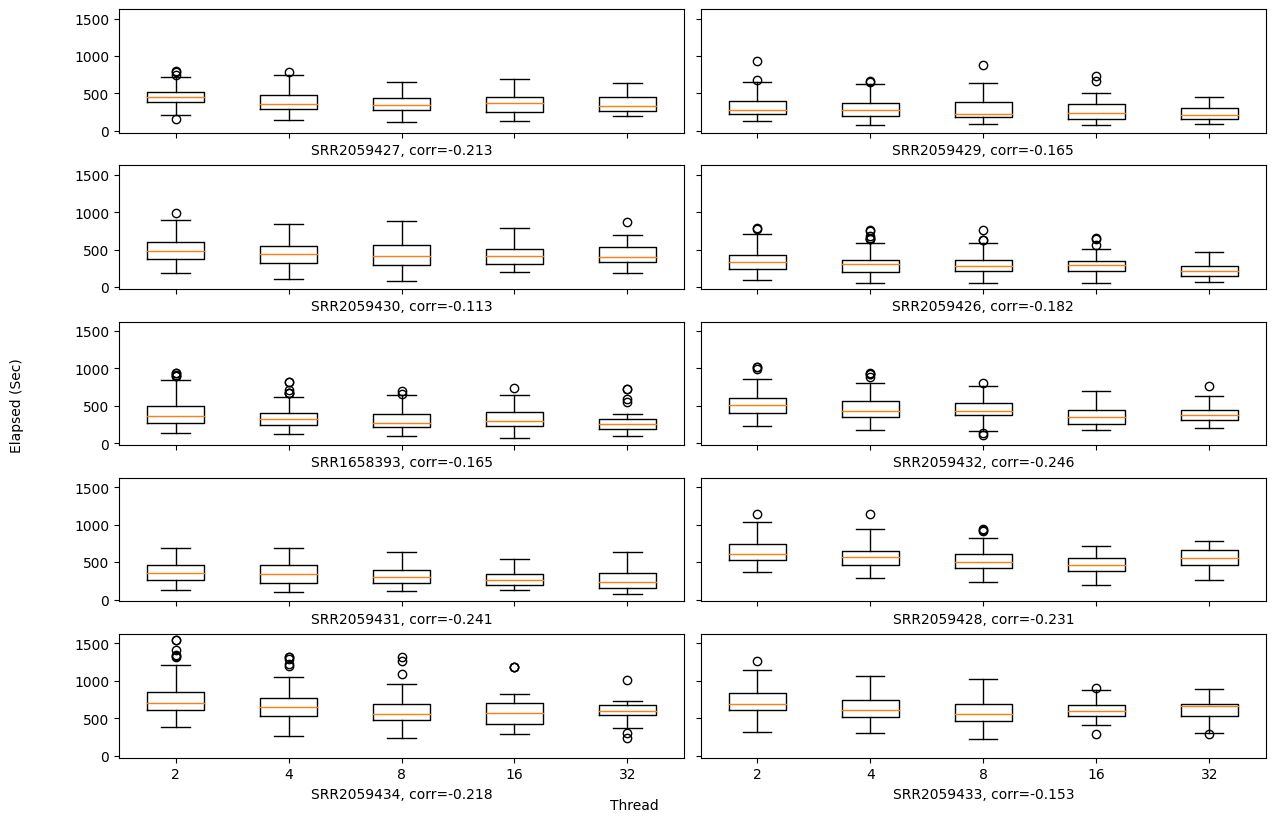

In [29]:
target = "threads"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[(completed_df["sra_id"] == s_id) & (completed_df["threads"] <= completed_df["alloc_cpu"])]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.45, 0.0, 'Thread', va='center', rotation='horizontal')

Text(0.5, 0.0, 'Thread')

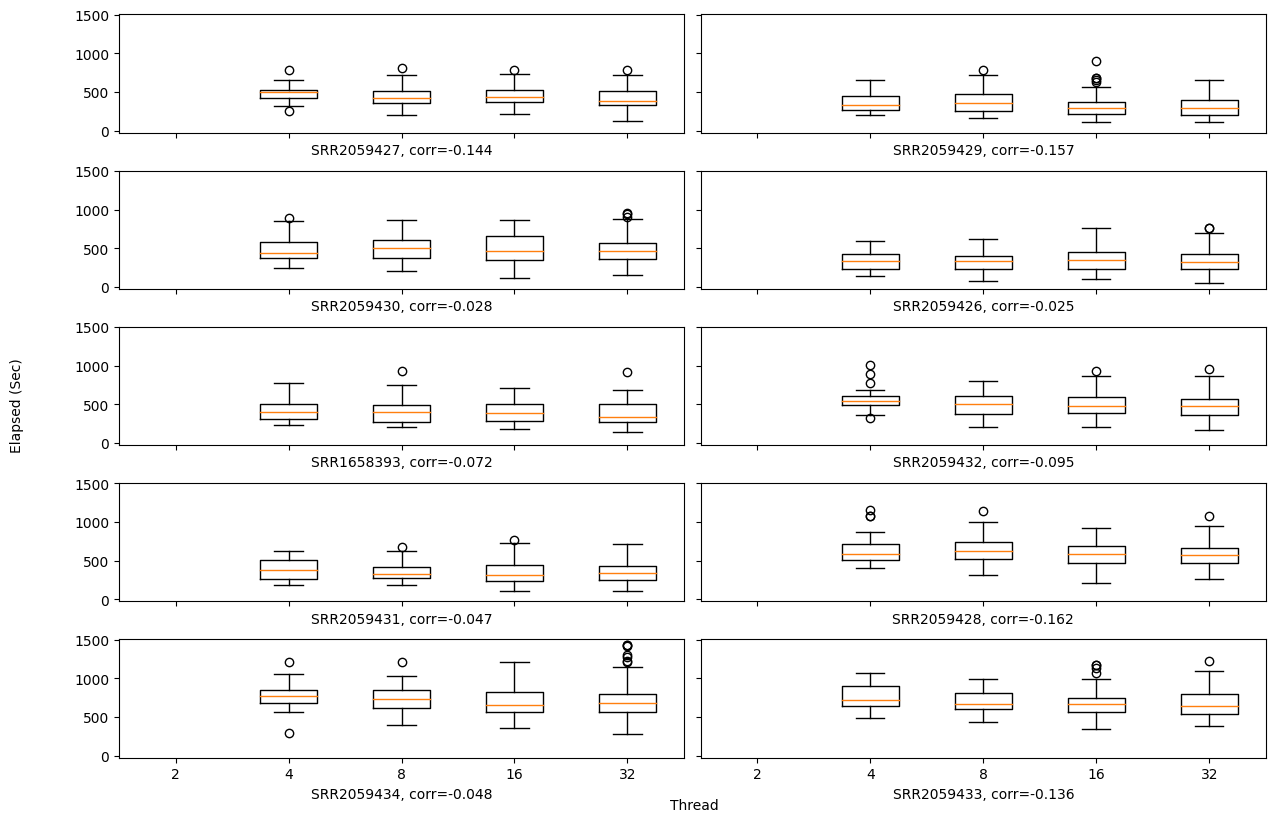

In [32]:
target = "threads"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[(completed_df["sra_id"] == s_id) & (completed_df["threads"] > completed_df["alloc_cpu"])]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Thread', va='center', rotation='horizontal')

## Post-execution Features

Text(0.5, 0.0, 'Average CPU Usage (%)')

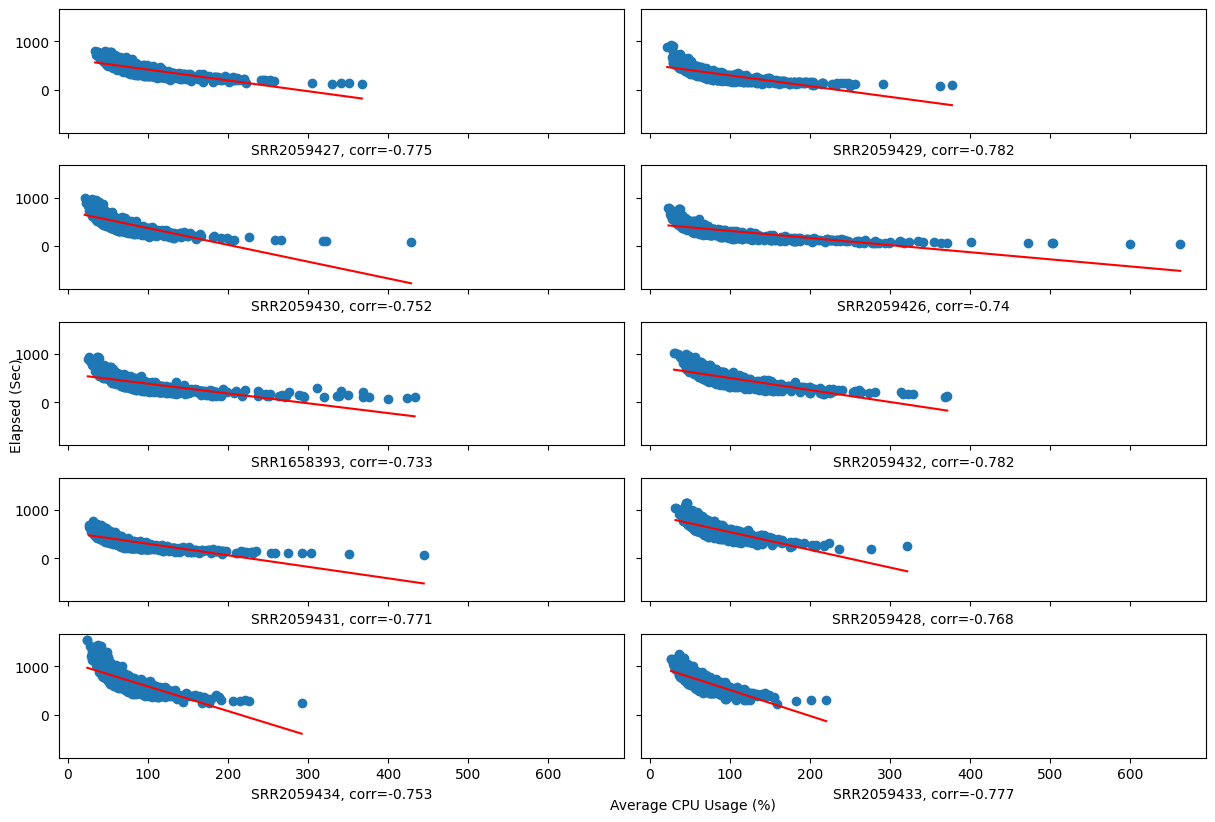

In [26]:
target = "ave_cpu"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Average CPU Usage (%)', va='center', rotation='horizontal')

Text(0.5, 0.0, 'Peak CPU Usage (%)')

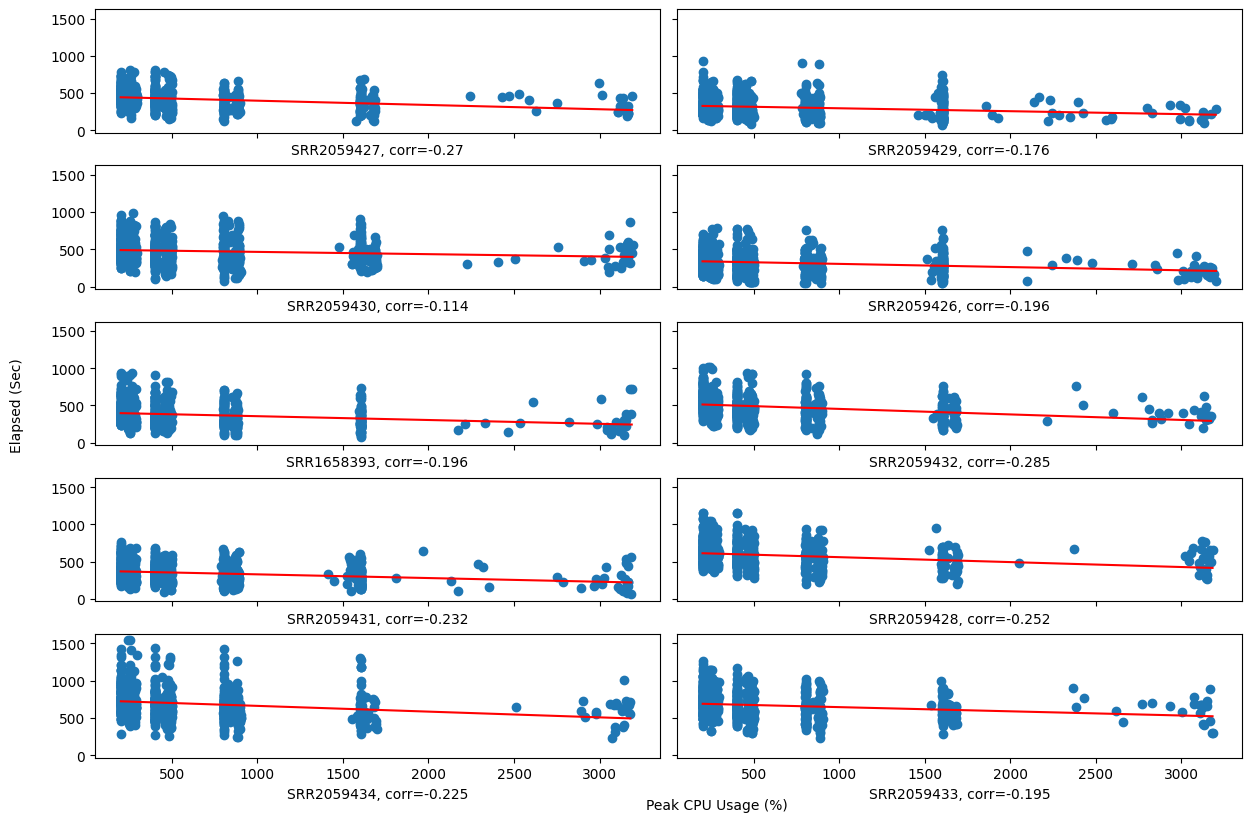

In [27]:
target = "peak_cpu"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Peak CPU Usage (%)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Average Physical Memory Usage (MB)')

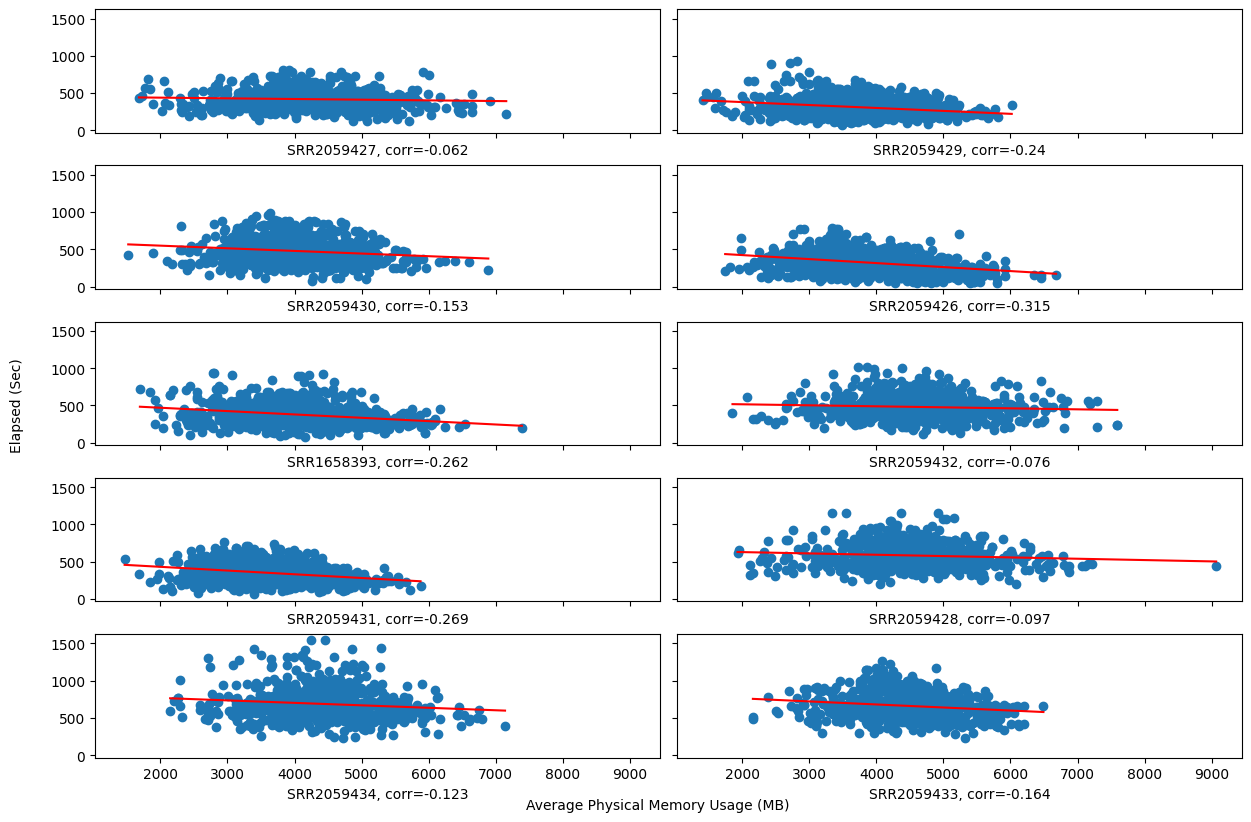

In [28]:
target = "ave_rss"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Average Physical Memory Usage (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Peak Physical Memory Usage (MB)')

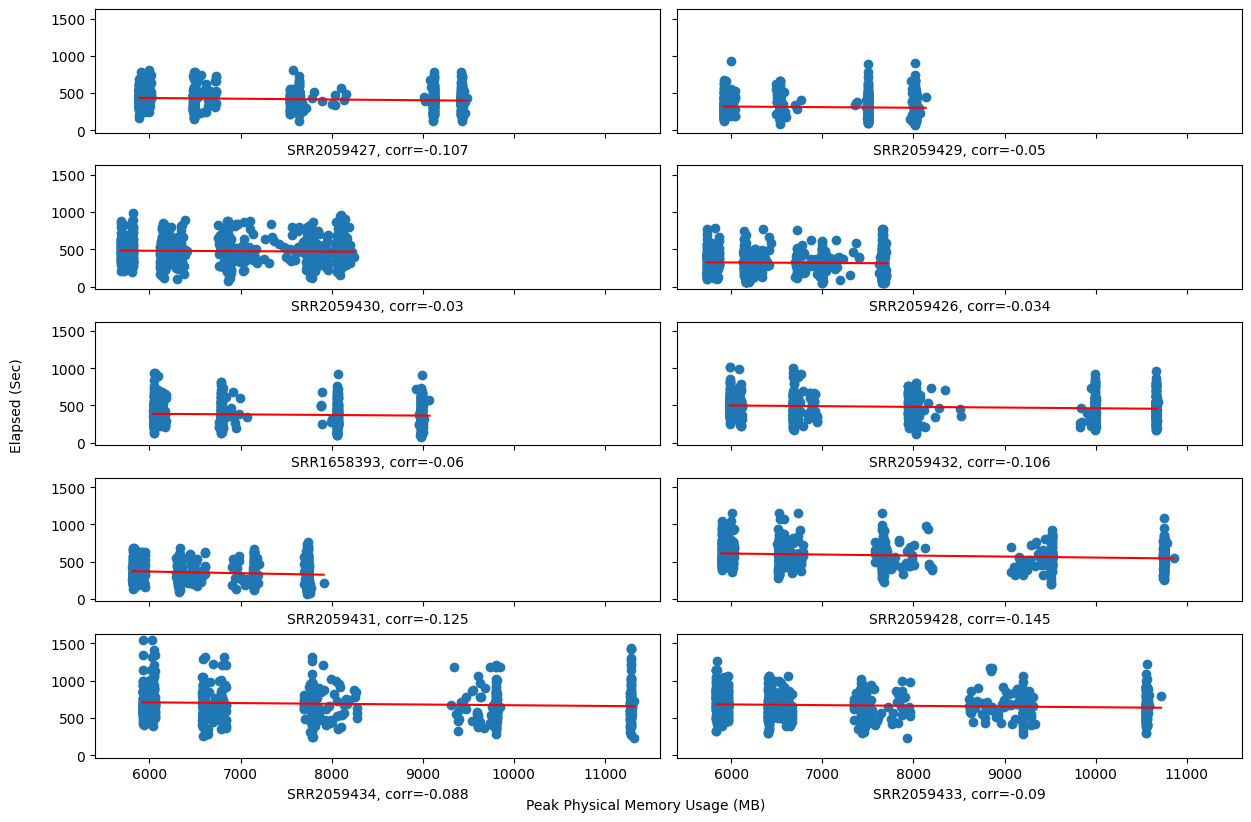

In [29]:
target = "peak_rss"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Peak Physical Memory Usage (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Average Virtual Memory Size (MB)')

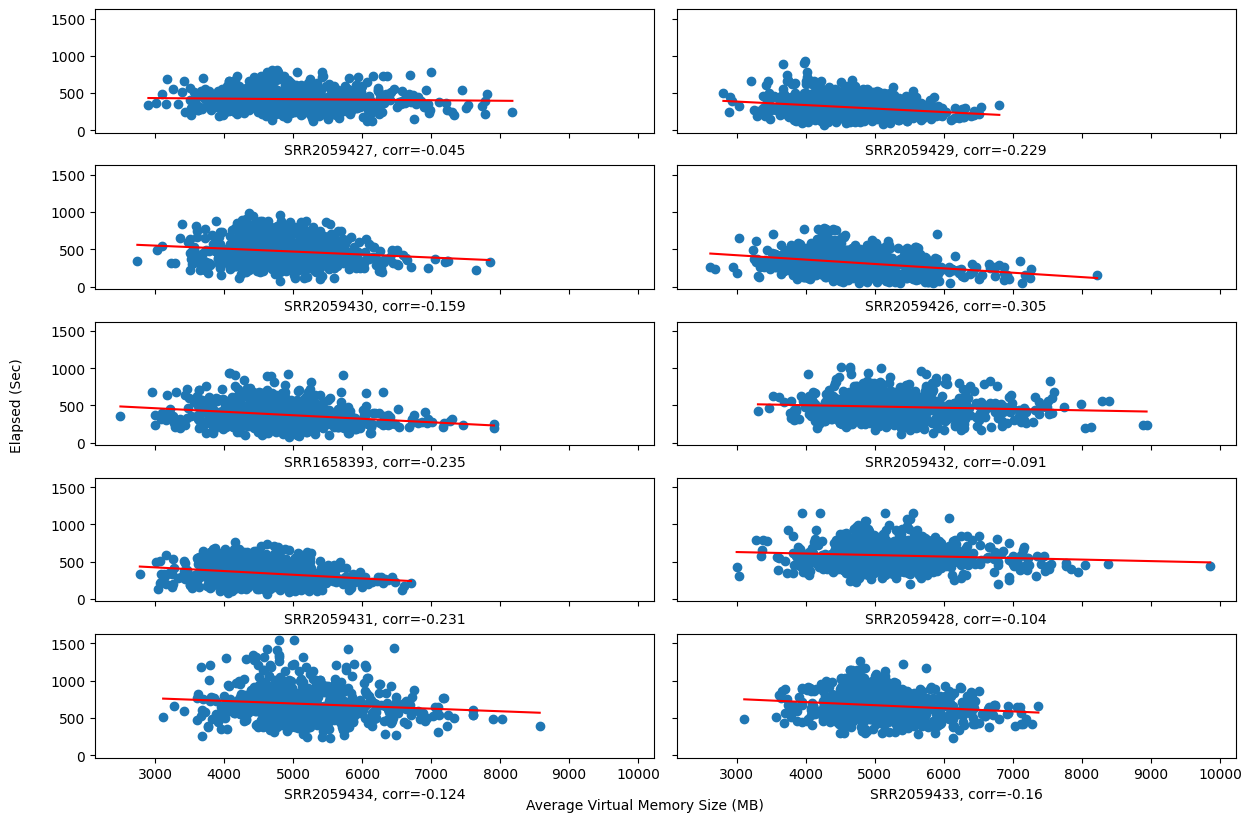

In [30]:
target = "ave_vsz"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Average Virtual Memory Size (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Peak Virtual Memory Size (MB)')

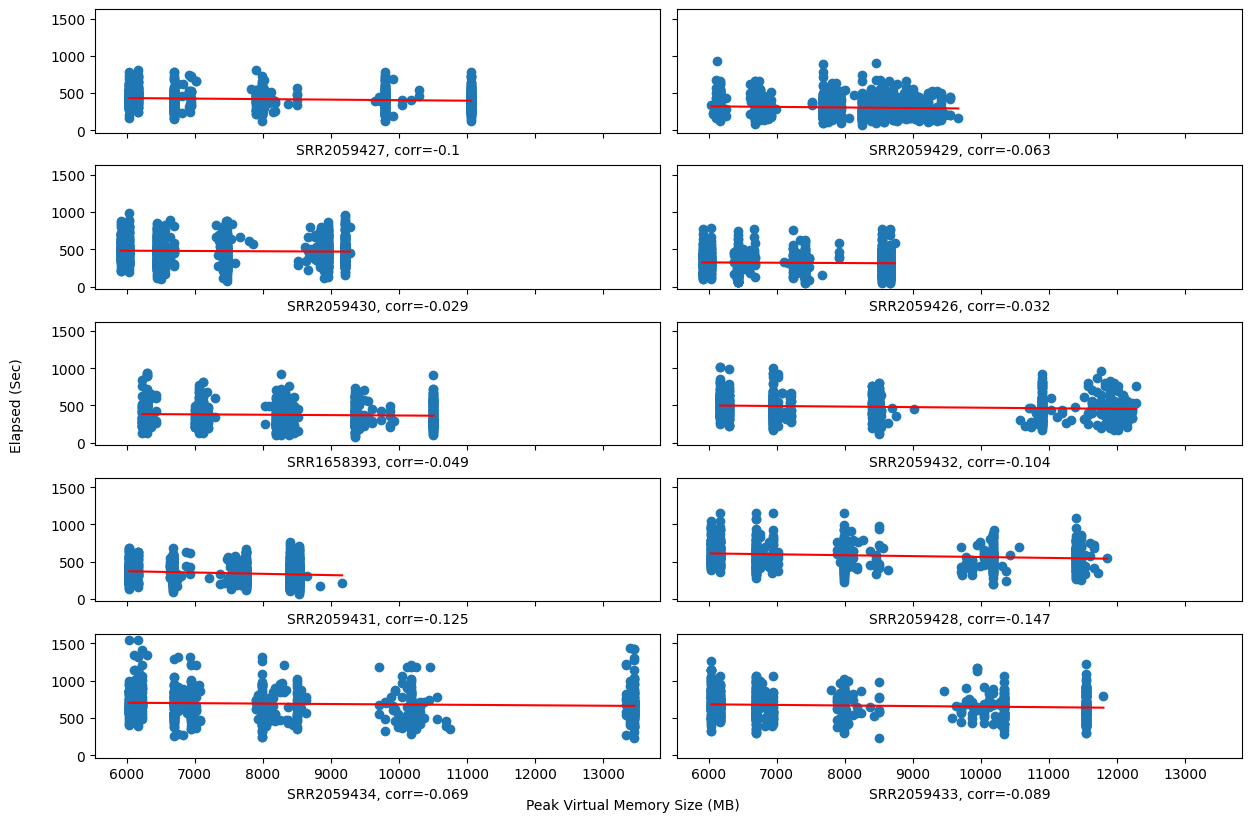

In [31]:
target = "peak_vsz"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Peak Virtual Memory Size (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Write Operations (MB)')

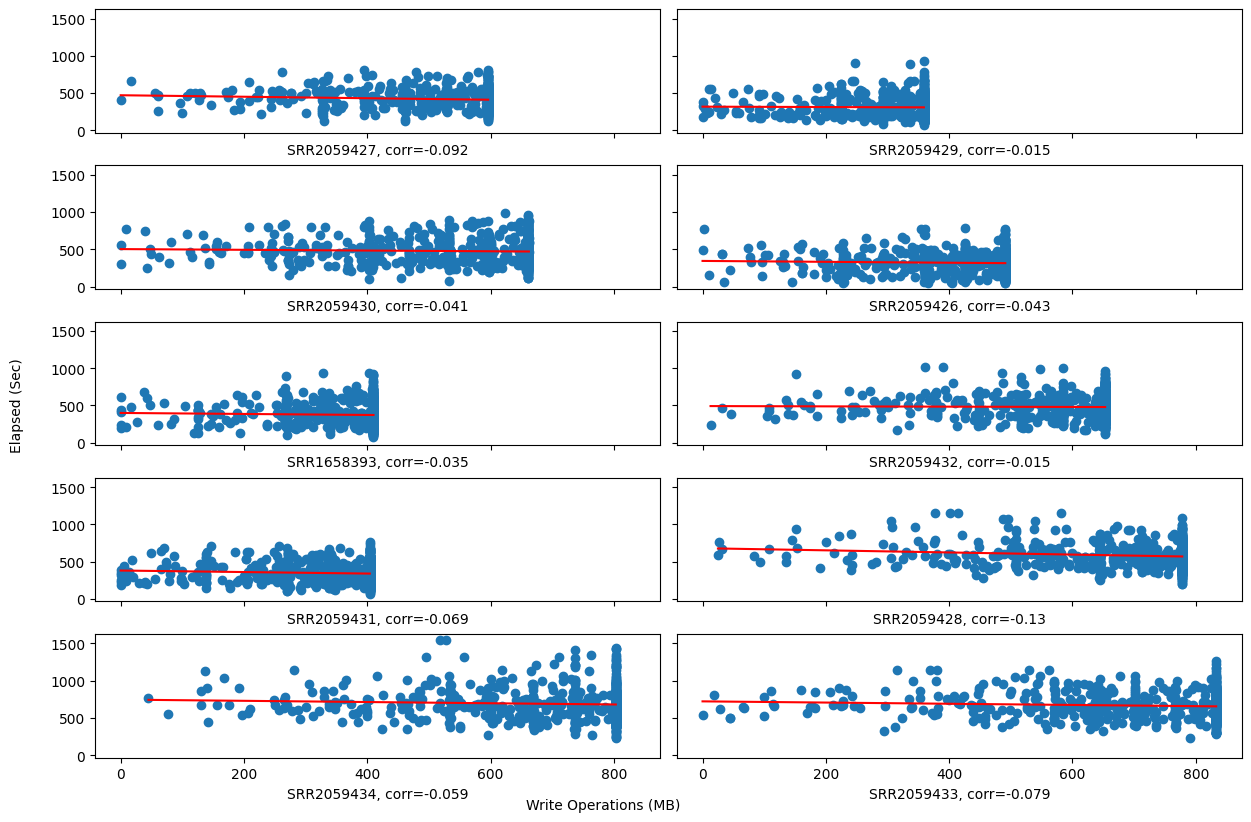

In [32]:
target = "write_bytes"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] // (1024**2)# B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
    
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Write Operations (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Read Operations (MB)')

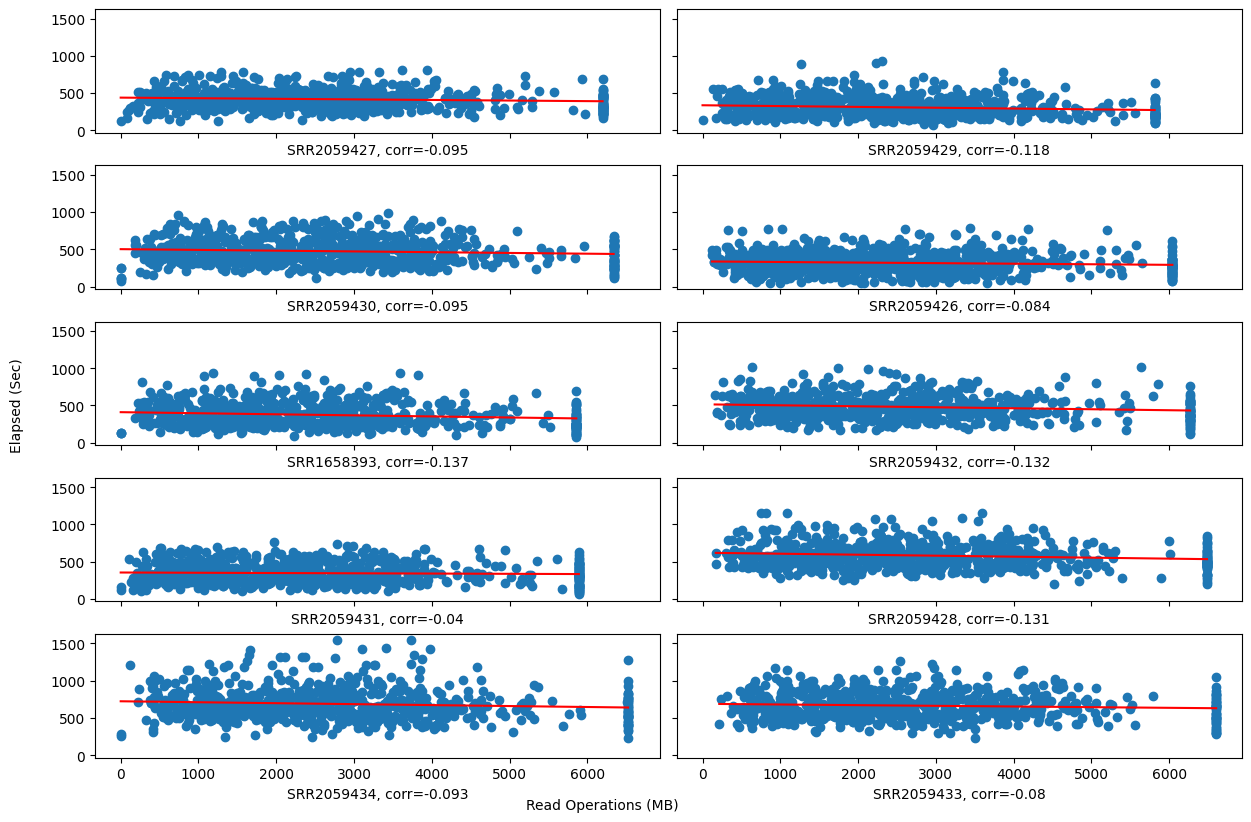

In [33]:
target = "read_bytes"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] // (1024**2)# B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
    
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Read Operations (MB)', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

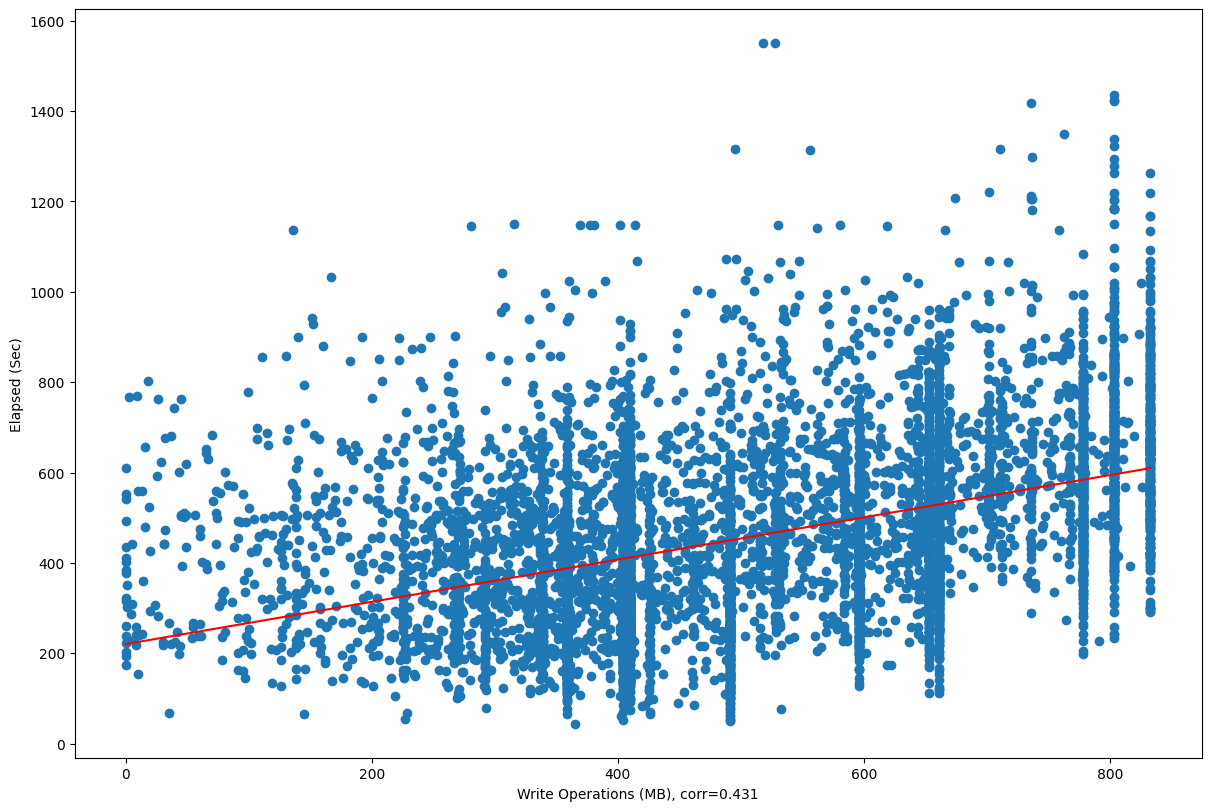

In [34]:
target = "write_bytes"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Write Operations (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

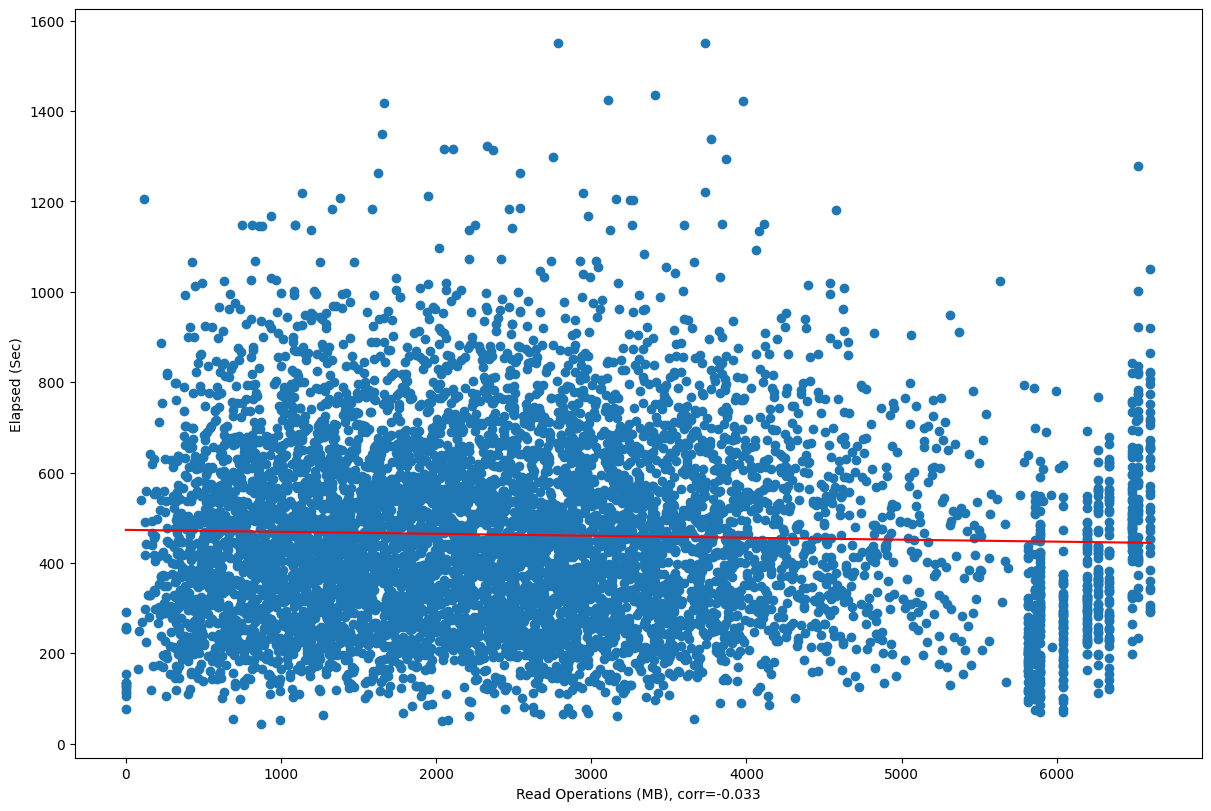

In [35]:
target = "read_bytes"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Read Operations (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

# Machine Learning

In [15]:
from scipy.stats.stats import pearsonr
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [16]:
def calculate_correlation(df, features, target):
    
    corr_dict = dict()
    y = df[target]
    for col in features:
        
        x = df[col]
        corr, _ =  pearsonr(x, y)
        corr_dict[col] = corr
    
  
    corr_df = pd.Series(corr_dict)
    corr_df.index = features
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda x:np.abs(x[1]), reverse=True))
    
    return sorted_corr_dict

def split_train_test(df, test_prop=0.25):
    separator_index = int(df.shape[0] * (1-test_prop))
    np.random.seed(42)
    df = df.sample(frac = 1)
    train_data, test_data = df.iloc[:separator_index], df.iloc[separator_index:]
    return train_data, test_data
    
def fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo):
    model = None
    score = -1
    
    if algo == "linear_regression":
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metrics.mean_absolute_error(y_test, y_pred)
    if algo == "random_forest":
        model = RandomForestRegressor(n_estimators = 1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metrics.mean_absolute_error(y_test, y_pred)
    
    
    return model, score

def get_k_of_best_model(models_dict):
    best_score = np.inf
    best_k = -1
    
    for k in models_dict:
        model = models_dict[k][0]
        score = models_dict[k][1]
        if score < best_score:
            best_score = score
            best_k = k
    return best_k


def get_best_pos_models(train_data, test_data, pre_features, pos_features, algo):
    df = pd.concat([train_data, test_data], ignore_index=False, axis=0)
    best_pos_models_dict = dict()
    for pos in pos_features:
        pos_corr_dict = calculate_correlation(df, pre_features, pos)
        sorted_pos_features = [feature for feature in pos_corr_dict]
        for i in range(len(sorted_pos_features)):
            k = i+1
            best_k_pos_features = sorted_pos_features[:k]
            
            X_train = train_data[best_k_pos_features].values
            y_train = train_data[pos].values
            X_test = test_data[best_k_pos_features].values
            y_test = test_data[pos].values
            
            model, score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)

            if pos not in best_pos_models_dict or score < best_pos_models_dict[pos][2]:
                best_pos_models_dict[pos] = [model, best_k_pos_features, score]

                
    return best_pos_models_dict

def build_two_stage(df, algo):
    
    pre_features = ['alloc_cpu', 
                    'alloc_mem_gb', 
                    'threads', 
                    'input_size',
                   'n_pack']
    
    pos_features = ['output_size', 
                    'ave_cpu', 
                    'peak_cpu',
                    'ave_vsz',
                    'peak_vsz',
                    'ave_rss',
                    'peak_rss',
                    'read_bytes',
                    'write_bytes']

    features = pre_features + pos_features
    

    train_data, test_data = split_train_test(df, 0.25)
    
    elapsed_corr_dict = calculate_correlation(df, features, 'elapsed_sec')
    
    # FEATURES FOR PREDICTING ELAPSED TIME
    sorted_elapsed_features = [feature for feature in elapsed_corr_dict]
    
#     pre_elapsed_features = [feature for feature in sorted_elapsed_features if feature in pre_features]
    
#     post_elapsed_features = [feature for feature in sorted_elapsed_featues if feature in post_features]
    
    best_pos_models_dict = get_best_pos_models(train_data, test_data, pre_features, pos_features, algo)
    
    elapsed_models_dict = dict()
    
    for i in range(len(sorted_elapsed_features)):
        k = i+1
        best_k_elapsed_features = sorted_elapsed_features[:k]

#         best_k_elapsed_pre_features = [feature for feature in best_k_elapsed_features if feature in pre_features]
#         best_k_elapsed_pos_features = [feature for feature in best_k_elapsed_features if feature in pos_features]
        
        for pos in pos_features:
            pos_model = best_pos_models_dict[pos][0]
            pos_pre_features = best_pos_models_dict[pos][1]
            
            X_train = train_data[pos_pre_features].values
            X_test = test_data[pos_pre_features].values
            
            train_data.loc[:, pos] = pos_model.predict(X_train)
            test_data.loc[:, pos] = pos_model.predict(X_test)
            
        
        X_train = train_data[best_k_elapsed_features].values
        y_train = train_data['elapsed_sec'].values
        X_test = test_data[best_k_elapsed_features].values
        y_test = test_data['elapsed_sec'].values
        
        elapsed_model, elapsed_score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)
        
        elapsed_models_dict[k] = [elapsed_model, elapsed_score]
        
    k_of_best_model = get_k_of_best_model(elapsed_models_dict)
    best_model = elapsed_models_dict[k_of_best_model][0]
    
    #return elapsed_models_dict, best_pos_models_dict, best_k_elapsed_features
    return best_model, best_pos_models_dict, sorted_elapsed_features[:k_of_best_model]

def build_single_stage(df, algo):
    pre_features = ['alloc_cpu', 
                    'alloc_mem_gb', 
                    'threads', 
                    'input_size',
                   'n_pack']
    
    pos_features = ['output_size', 
                    'ave_cpu', 
                    'peak_cpu',
                    'ave_vsz',
                    'peak_vsz',
                    'ave_rss',
                    'peak_rss',
                    'read_bytes',
                    'write_bytes']
    
    train_data, test_data = split_train_test(df, 0.25)
    
    features = pre_features + pos_features
    
    corr_dict = calculate_correlation(df, features, 'elapsed_sec')
    
    sorted_elapsed_features = [feature for feature in corr_dict if feature in pre_features]
    
    elapsed_models_dict = dict()
    
    for i in range(len(sorted_elapsed_features)):
        k = i+1
        best_k_elapsed_features = sorted_elapsed_features[:k]
        
        X_train = train_data[best_k_elapsed_features].values
        y_train = train_data['elapsed_sec'].values
        X_test = test_data[best_k_elapsed_features].values
        y_test = test_data['elapsed_sec'].values
        
        elapsed_model, elapsed_score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)
        
        elapsed_models_dict[k] = [elapsed_model, elapsed_score]
    
    k_of_best_model = get_k_of_best_model(elapsed_models_dict)
    best_model = elapsed_models_dict[k_of_best_model][0]
    
    return best_model, sorted_elapsed_features[:k_of_best_model]

In [17]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]
completed_df

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,threads,sra_id,input_size,output_size,...,n_pack,pack_id,ave_cpu,peak_cpu,ave_vsz,peak_vsz,ave_rss,peak_rss,read_bytes,write_bytes
0,12833,single_bwa.sh,8,8,440,COMPLETED,8,SRR2059427,1006917152,625008229,...,4.0,472.0,100.379081,803.0,5.630365e+09,8.277459e+09,4.792467e+09,7.909827e+09,1.314005e+09,625008640.0
1,14184,single_bwa.sh,8,16,695,COMPLETED,2,SRR2059430,1155384344,694113997,...,3.0,1030.0,29.966989,252.0,5.060029e+09,6.199386e+09,4.391293e+09,5.990662e+09,4.375663e+09,544935936.0
2,19657,single_bwa.sh,8,32,277,COMPLETED,16,SRR1658393,652502436,430124654,...,4.0,403.0,130.805874,803.0,4.811460e+09,9.808855e+09,3.916531e+09,9.419117e+09,1.212543e+09,430137344.0
4,16251,single_bwa.sh,4,8,417,COMPLETED,8,SRR2059431,687297970,423971216,...,4.0,1888.0,64.410060,402.0,5.071821e+09,8.126468e+09,4.373864e+09,7.494259e+09,2.125324e+09,381620224.0
5,12580,single_bwa.sh,32,32,575,COMPLETED,2,SRR2059434,1350726332,842951903,...,2.0,364.0,70.036475,282.0,3.902759e+09,6.467822e+09,3.493602e+09,6.230659e+09,2.454147e+09,842985472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,12270,single_bwa.sh,32,64,281,COMPLETED,2,SRR2059431,687297970,423971216,...,2.0,245.0,62.600303,242.0,5.444829e+09,6.333604e+09,4.980751e+09,6.114710e+09,2.292916e+09,353857536.0
7991,12079,single_bwa.sh,2,16,262,COMPLETED,32,SRR2059429,604731342,377159582,...,2.0,163.0,92.648478,201.0,5.752623e+09,8.797225e+09,4.082573e+09,8.410898e+09,2.662113e+09,377167872.0
7992,19399,single_bwa.sh,4,64,855,COMPLETED,2,SRR2059433,1434756540,874254433,...,3.0,296.0,38.758004,276.0,4.716506e+09,6.467822e+09,3.826116e+09,6.203412e+09,2.293314e+09,116674560.0
7993,19981,single_bwa.sh,32,16,780,COMPLETED,32,SRR2059428,1311319762,816740889,...,2.0,537.0,79.797925,3118.0,6.429074e+09,1.195914e+10,5.833991e+09,1.126584e+10,5.125652e+08,816754688.0


In [18]:
lr_single_stage_elapsed_model, lr_single_stage_features = build_single_stage(completed_df, "linear_regression")

In [19]:
rf_single_stage_elapsed_model, rf_single_stage_features = build_single_stage(completed_df, "random_forest")

In [20]:
lr_second_stage_elapsed_model, lr_first_stage_models, lr_second_stage_features = build_two_stage(completed_df, 'linear_regression')

In [21]:
rf_second_stage_elapsed_model, rf_first_stage_models, rf_second_stage_features = build_two_stage(completed_df, 'random_forest')

In [22]:
def absolute_error(actual, calculated):
    n = len(actual)
    result = np.zeros(n)
    for i in range(n):
        result[i] = abs(actual[i]-calculated[i])
    return result

def error(actual, calculated):
    n = len(actual)
    result = np.zeros(n)
    for i in range(n):
        result[i] = calculated[i]-actual[i]
    return result

def evaluate_single_model(model, features, target, df, metrics):
    train_data, test_data = split_train_test(df, 0.25)
    X_test = test_data[features].values
    y_test = test_data[target].values
    y_pred = model.predict(X_test)
    scores = None
    if metrics == 'absolute_error':
        scores = absolute_error(y_test, y_pred)
    if metrics == 'squared_error':
        scores = squared_error(y_test, y_pred)
    if metrics == 'error':
        scores = error(y_test, y_pred)
    return scores

def evaluate_two_stage_model(first_stage_models, second_stage_model, features, target, df, metrics):
    train_data, test_data = split_train_test(df, 0.25)
    
    pos_features = ['output_size', 
                'ave_cpu', 
                'peak_cpu',
                'ave_vsz',
                'peak_vsz',
                'ave_rss',
                'peak_rss',
                'read_bytes',
                'write_bytes']

    
    for feature in features:
        if feature in pos_features:
            first_stage_model = first_stage_models[feature][0]
            pre_features = first_stage_models[feature][1]
            test_data.loc[:, feature] = first_stage_model.predict(test_data[pre_features].values)    
    
    X_test = test_data[features].values
    y_test = test_data[target].values
    
    y_pred = second_stage_model.predict(X_test)
    
    scores = None
    if metrics == 'absolute_error':
        scores = absolute_error(y_test, y_pred)
    if metrics == 'squared_error':
        scores = squared_error(y_test, y_pred)
    if metrics == 'error':
        scores = error(y_test, y_pred)
    return scores
    

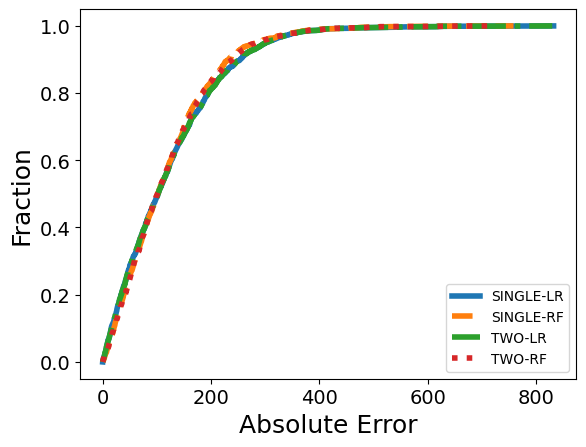

In [23]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

lr_single_ae = evaluate_single_model(lr_single_stage_elapsed_model, lr_single_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
rf_single_ae = evaluate_single_model(rf_single_stage_elapsed_model, rf_single_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
lr_two_ae = evaluate_two_stage_model(lr_first_stage_models, lr_second_stage_elapsed_model, lr_second_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
rf_two_ae = evaluate_two_stage_model(rf_first_stage_models, rf_second_stage_elapsed_model, rf_second_stage_features, 'elapsed_sec', completed_df, 'absolute_error')


sorted_lr_single_ae = np.sort(lr_single_ae)
frac_lr_single_ae = np.arange(len(lr_single_ae)) / len(lr_single_ae)

sorted_rf_single_ae = np.sort(rf_single_ae)
frac_rf_single_ae = np.arange(len(rf_single_ae)) / len(rf_single_ae)

sorted_lr_two_ae = np.sort(lr_two_ae)
frac_lr_two_ae = np.arange(len(lr_two_ae)) / len(lr_two_ae)

sorted_rf_two_ae = np.sort(rf_two_ae)
frac_rf_two_ae = np.arange(len(rf_two_ae)) / len(rf_two_ae)

plt.plot(sorted_lr_single_ae, frac_lr_single_ae, '-', label='SINGLE-LR', linewidth=4)
plt.plot(sorted_rf_single_ae, frac_rf_single_ae, '--', label='SINGLE-RF', linewidth=4)
plt.plot(sorted_lr_two_ae, frac_lr_two_ae, '-.', label='TWO-LR', linewidth=4)
plt.plot(sorted_rf_two_ae, frac_rf_two_ae, ':', label='TWO-RF', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Absolute Error', fontsize=18)
plt.ylabel('Fraction', fontsize=18)
plt.legend()

# train_data, test_data = split_train_test(df, 0.25)



# # X_train = train_data[lr_single_stage_features].values
# # y_train = train_data['elapsed_sec'].values
# X_test = test_data[lr_single_stage_features].values
# y_test = test_data['elapsed_sec'].values
# y_pred = lr_single_stage_elapsed_model.predict(X_test)
# lr_single_ae = absolute_error(y_test, y_pred)

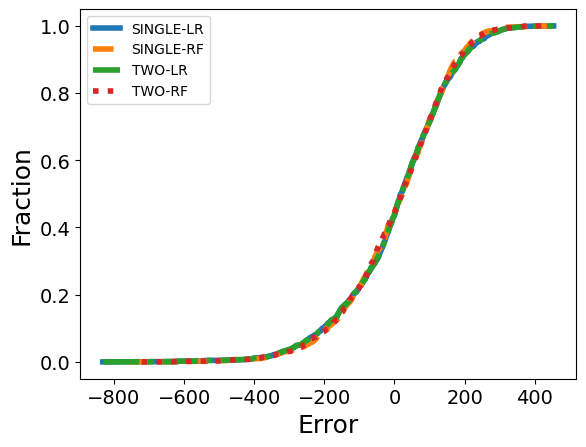

In [24]:
metrics = 'error'
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

lr_single_e = evaluate_single_model(lr_single_stage_elapsed_model, lr_single_stage_features, 'elapsed_sec', completed_df, metrics)
rf_single_e = evaluate_single_model(rf_single_stage_elapsed_model, rf_single_stage_features, 'elapsed_sec', completed_df, metrics)
lr_two_e = evaluate_two_stage_model(lr_first_stage_models, lr_second_stage_elapsed_model, lr_second_stage_features, 'elapsed_sec', completed_df, metrics)
rf_two_e = evaluate_two_stage_model(rf_first_stage_models, rf_second_stage_elapsed_model, rf_second_stage_features, 'elapsed_sec', completed_df, metrics)


sorted_lr_single_e = np.sort(lr_single_e)
frac_lr_single_e = np.arange(len(lr_single_e)) / len(lr_single_e)

sorted_rf_single_e = np.sort(rf_single_e)
frac_rf_single_e = np.arange(len(rf_single_e)) / len(rf_single_e)

sorted_lr_two_e = np.sort(lr_two_e)
frac_lr_two_e = np.arange(len(lr_two_e)) / len(lr_two_e)

sorted_rf_two_e = np.sort(rf_two_e)
frac_rf_two_e = np.arange(len(rf_two_ae)) / len(rf_two_e)

plt.plot(sorted_lr_single_e, frac_lr_single_e, '-', label='SINGLE-LR', linewidth=4)
plt.plot(sorted_rf_single_e, frac_rf_single_e, '--', label='SINGLE-RF', linewidth=4)
plt.plot(sorted_lr_two_e, frac_lr_two_e, '-.', label='TWO-LR', linewidth=4)
plt.plot(sorted_rf_two_e, frac_rf_two_e, ':', label='TWO-RF', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Error', fontsize=18)
plt.ylabel('Fraction', fontsize=18)
plt.legend()

# train_data, test_data = split_train_test(df, 0.25)



# # X_train = train_data[lr_single_stage_features].values
# # y_train = train_data['elapsed_sec'].values
# X_test = test_data[lr_single_stage_features].values
# y_test = test_data['elapsed_sec'].values
# y_pred = lr_single_stage_elapsed_model.predict(X_test)
# lr_single_ae = absolute_error(y_test, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


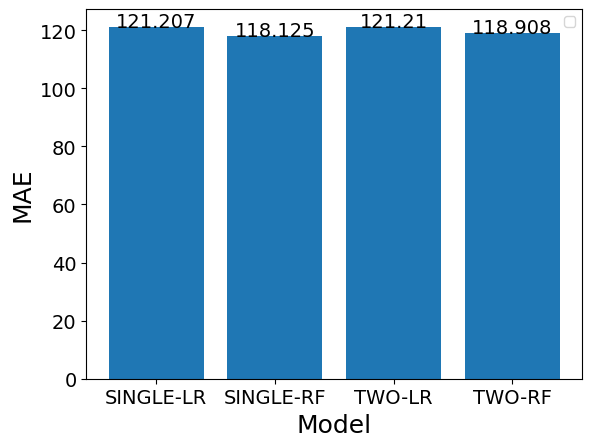

In [25]:
x = ['SINGLE-LR', 'SINGLE-RF', 'TWO-LR', 'TWO-RF']
y = [np.mean(lr_single_ae), 
     np.mean(rf_single_ae),
    np.mean(lr_two_ae),
    np.mean(rf_two_ae)]

for i in range(len(y)):
    plt.text(i, y[i], np.round(y[i],3),ha="center", fontsize=14)

plt.bar(x, y)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Model', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.legend()